# Satellite Data

## Now use a statistical-based filter selection method to select the most discriminant feature.



Load the necessary libraries and the data

In [3]:
# Step 1: Load and Preprocess Data
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Fetch the dataset
statlog_landsat_satellite = fetch_ucirepo(id=146) 
  
# data (as pandas dataframes) 
X = statlog_landsat_satellite.data.features 
y = statlog_landsat_satellite.data.targets 


In [23]:
df = X.assign(y=y)

Now, we report one-to other t-test p-values

In [36]:
from scipy import stats

class_data = {}
for class_label in y["class"].unique():
    class_data[class_label] = df[df["y"] == class_label]

results = []
classes = list(class_data.keys())

for i in range(len(classes)):
    for j in range(i+1, len(classes)):
        class1 = class_data[classes[i]]
        class2 = class_data[classes[j]]
        for column in df.columns[:-1]:
            t_statistic, p_value = stats.ttest_ind(class1[column], class2[column])
            results.append((column, classes[i], classes[j], t_statistic, p_value))

result_t_test = pd.DataFrame(results, columns = ['Feature', 'Class 1', 'Class2', 't-statisitc', 'p-value'])
result_t_test
#significane 0.05
#alpha = 0.05

#selected_features_t_test = result_t_test[result_t_test['p-value'] < alpha]

#print(selected_features_t_test)

,Feature,Class 1,Class2,t-statisitc,p-value
0,Attribute1,3,4,30.096091,3.281795e-164
1,Attribute2,3,4,29.127384,1.453090e-155
2,Attribute3,3,4,32.072758,3.645964e-182
3,Attribute4,3,4,30.919016,1.227980e-171
4,Attribute5,3,4,32.688717,7.787227e-188
...,...,...,...,...,...
535,Attribute32,2,1,44.236078,1.618743e-307
536,Attribute33,2,1,-36.648910,1.163164e-230
537,Attribute34,2,1,-79.278275,0.000000e+00
538,Attribute35,2,1,8.362560,1.065254e-16


Analogously, we performed the One-to-Other KS- p-values 

In [35]:
ks_results = []
classes = list(class_data.keys())

for i in range(len(classes)):
    for j in range(i+1, len(classes)):
        class1 = class_data[classes[i]]
        class2 = class_data[classes[j]]
        for column in df.columns[:-1]:
            #ks
            ks_statistic, ks_p_value = stats.ks_2samp(class1[column], class2[column])
            ks_results.append((column, classes[i], classes[j], ks_statistic, ks_p_value))


result_ks_test = pd.DataFrame(ks_results, columns = ['Feature', 'Class 1', 'Class2', 't-statisitc', 'p-value'])
result_ks_test

,Feature,Class 1,Class2,t-statisitc,p-value
0,Attribute1,3,4,0.590553,1.081019e-139
1,Attribute2,3,4,0.618637,1.782161e-154
2,Attribute3,3,4,0.620436,1.980902e-155
3,Attribute4,3,4,0.596374,1.128059e-142
4,Attribute5,3,4,0.614752,2.349314e-152
...,...,...,...,...,...
535,Attribute32,2,1,0.781465,1.822375e-294
536,Attribute33,2,1,0.690157,3.951711e-221
537,Attribute34,2,1,0.865572,4.051338e-322
538,Attribute35,2,1,0.177414,9.829564e-14


Now using ROC AUC

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score

#separte in train and test datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

roc_auc_results = []

for feature in X_train.columns:
    clf = DecisionTreeClassifier()

    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    y_scored = clf.predict_proba(X_test[feature].to_frame())

    roc_auc_results.append(roc_auc_score(y_test, y_scored, multi_class='ovr'))

results_roc = pd.Series(roc_auc_results)

results_roc.index = X_train.columns

results_roc_df = pd.DataFrame({
    'Feature': results_roc.index,
    'roc_auc': results_roc.values
})

# Muestra el DataFrame
results_roc_df

,Feature,roc_auc
0,Attribute1,0.841729
1,Attribute2,0.841859
2,Attribute3,0.796173
3,Attribute4,0.827412
4,Attribute5,0.858386
5,Attribute6,0.851289
6,Attribute7,0.796095
7,Attribute8,0.827831
8,Attribute9,0.845229
9,Attribute10,0.837111


Adjust the p_values for FDR

In [38]:
from statsmodels.stats.multitest import fdrcorrection

# Adjust p-values for FDR (both t-test and KS-test)
t_test_p_values = result_t_test['p-value'].values
ks_p_values = result_ks_test['p-value'].values

t_test_adjusted = multipletests(t_test_p_values, method='fdr_bh')[1]
ks_adjusted = multipletests(ks_p_values, method='fdr_bh')[1]

result_t_test['FDR-adjusted p-value'] = t_test_adjusted
result_ks_test['FDR-adjusted p-value'] = ks_adjusted

Compare the ranking of the p-values for the three different methods.

First, we are going to calculate the mean of the corrected p values for each feature for the t-test and ks test.

In [55]:
# ks
mean_p_values_ks = result_ks_test.groupby('Feature')['FDR-adjusted p-value'].mean().reset_index()
mean_p_values_ks.rename(columns={'p-value': 'FDR-adjusted p-value'}, inplace=True)
mean_p_values_df_ks = mean_p_values_ks

# t-test
mean_p_values_t_test = result_t_test.groupby('Feature')['FDR-adjusted p-value'].mean().reset_index()
mean_p_values_t_test.rename(columns={'p-value': 'FDR-adjusted p-value'}, inplace=True)
mean_p_values_df_t = mean_p_values_t_test

Now, we combined the results in a dataframe

In [59]:
ranking_df = pd.merge(mean_p_values_df_t[['Feature', 'FDR-adjusted p-value']],
                      mean_p_values_df_ks[['Feature', 'FDR-adjusted p-value']],
                      on='Feature', suffixes=('_t_test', '_ks'))
ranking_df = pd.merge(ranking_df, results_roc_df, on='Feature')

In [60]:
ranking_df

,Feature,FDR-adjusted p-value_t_test,FDR-adjusted p-value_ks,roc_auc
0,Attribute1,6.610641e-15,1.516973e-30,0.841729
1,Attribute10,6.834457e-26,1.164221e-46,0.837111
2,Attribute11,1.156428e-02,4.040214e-04,0.797725
3,Attribute12,2.865018e-10,4.172099e-23,0.820930
4,Attribute13,8.625106e-15,3.112649e-31,0.859329
5,Attribute14,6.338784e-15,8.703658e-44,0.853800
6,Attribute15,5.174310e-06,1.646539e-07,0.806963
7,Attribute16,1.464519e-05,9.195123e-30,0.842519
8,Attribute17,4.161674e-25,1.460148e-42,0.876212
9,Attribute18,4.891669e-16,4.130507e-51,0.878900


/var/folders/h4/v6kv36fs44lg2yrrlf2z2jyr0000gn/T/ipykernel_90249/1083825134.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='roc_auc', y='Feature', data=ranking_df.sort_values('roc_auc', ascending=False), palette='viridis')


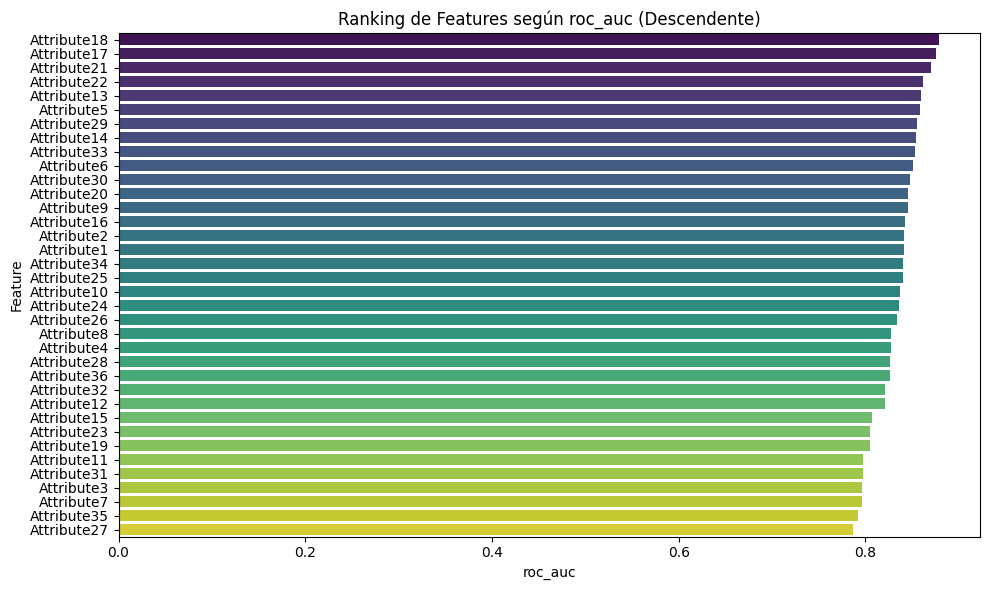

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

#SORTED BY AUC
plt.figure(figsize=(10, 6))
sns.barplot(x='roc_auc', y='Feature', data=ranking_df.sort_values('roc_auc', ascending=False), palette='viridis')
plt.title('Ranking de Features según roc_auc (Descendente)')
plt.xlabel('roc_auc')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

/var/folders/h4/v6kv36fs44lg2yrrlf2z2jyr0000gn/T/ipykernel_90249/1207628925.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='FDR-adjusted p-value_t_test', y='Feature', data=ranking_df.sort_values('FDR-adjusted p-value_t_test'), palette='viridis')


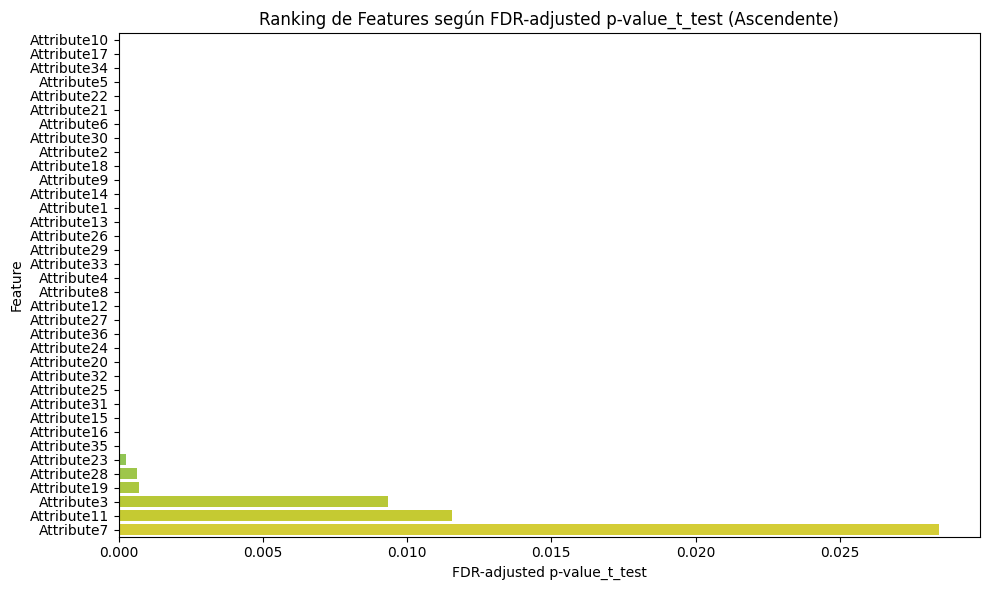

In [64]:
#SORTED BY T-TEST
plt.figure(figsize=(10, 6))
sns.barplot(x='FDR-adjusted p-value_t_test', y='Feature', data=ranking_df.sort_values('FDR-adjusted p-value_t_test'), palette='viridis')
plt.title('Ranking de Features según FDR-adjusted p-value_t_test (Ascendente)')
plt.xlabel('FDR-adjusted p-value_t_test')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

/var/folders/h4/v6kv36fs44lg2yrrlf2z2jyr0000gn/T/ipykernel_90249/2410965441.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='FDR-adjusted p-value_ks', y='Feature', data=ranking_df.sort_values('FDR-adjusted p-value_ks'), palette='viridis')


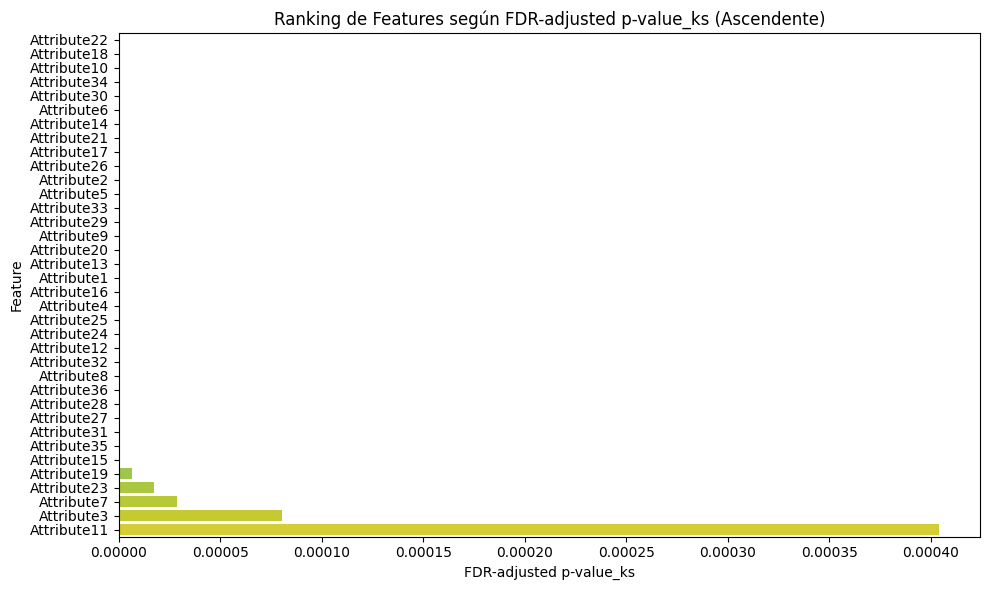

In [66]:
#sorted by ks
plt.figure(figsize=(10, 6))
sns.barplot(x='FDR-adjusted p-value_ks', y='Feature', data=ranking_df.sort_values('FDR-adjusted p-value_ks'), palette='viridis')
plt.title('Ranking de Features según FDR-adjusted p-value_ks (Ascendente)')
plt.xlabel('FDR-adjusted p-value_ks')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Select any heuristic feature selection method. Compare the ranking to the statistical methods.
We are going to use the Chi-Square Test method

In [73]:
import sklearn.feature_selection as FS

chi_values, p_values = FS.chi2(X, y)

indices_chi = np.argsort(chi_values)[::-1]

chi_df = pd.DataFrame({
    'Feature': X.columns[indices_chi],  # Use the indices to sort the feature names
    'chi': chi_values[indices_chi]      # Use the sorted chi values
})

print(chi_df)



        Feature           chi
0   Attribute18  31767.095869
1   Attribute22  30510.985521
2   Attribute14  29725.448977
3    Attribute6  29233.716925
4   Attribute30  29215.811159
5   Attribute34  28780.786126
6    Attribute2  28208.488641
7   Attribute10  27851.344253
8   Attribute26  27238.571806
9   Attribute20  20208.148464
10  Attribute16  19385.145654
11  Attribute24  19358.263583
12  Attribute32  18444.822271
13   Attribute8  18371.176465
14  Attribute28  18054.859025
15  Attribute12  17974.249954
16  Attribute36  17596.603313
17   Attribute4  17555.029307
18  Attribute17  13296.630900
19  Attribute21  12813.377998
20  Attribute13  12542.874406
21   Attribute5  12336.219215
22  Attribute29  12323.142085
23  Attribute33  11974.142740
24   Attribute1  11856.141364
25   Attribute9  11853.039207
26  Attribute25  11772.071611
27  Attribute19  11144.625537
28  Attribute15  10698.193478
29  Attribute23  10574.750434
30  Attribute31  10202.998419
31   Attribute7  10199.845914
32  Attrib

In [74]:
ranking_df = pd.merge(ranking_df, chi_df, on='Feature')
ranking_df

,Feature,FDR-adjusted p-value_t_test,FDR-adjusted p-value_ks,roc_auc,chi
0,Attribute1,6.610641e-15,1.516973e-30,0.841729,11856.141364
1,Attribute10,6.834457e-26,1.164221e-46,0.837111,27851.344253
2,Attribute11,1.156428e-02,4.040214e-04,0.797725,9896.457428
3,Attribute12,2.865018e-10,4.172099e-23,0.820930,17974.249954
4,Attribute13,8.625106e-15,3.112649e-31,0.859329,12542.874406
5,Attribute14,6.338784e-15,8.703658e-44,0.853800,29725.448977
6,Attribute15,5.174310e-06,1.646539e-07,0.806963,10698.193478
7,Attribute16,1.464519e-05,9.195123e-30,0.842519,19385.145654
8,Attribute17,4.161674e-25,1.460148e-42,0.876212,13296.630900
9,Attribute18,4.891669e-16,4.130507e-51,0.878900,31767.095869


/var/folders/h4/v6kv36fs44lg2yrrlf2z2jyr0000gn/T/ipykernel_90249/668243646.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='chi', y='Feature', data=ranking_df.sort_values('chi', ascending=False), palette='viridis')


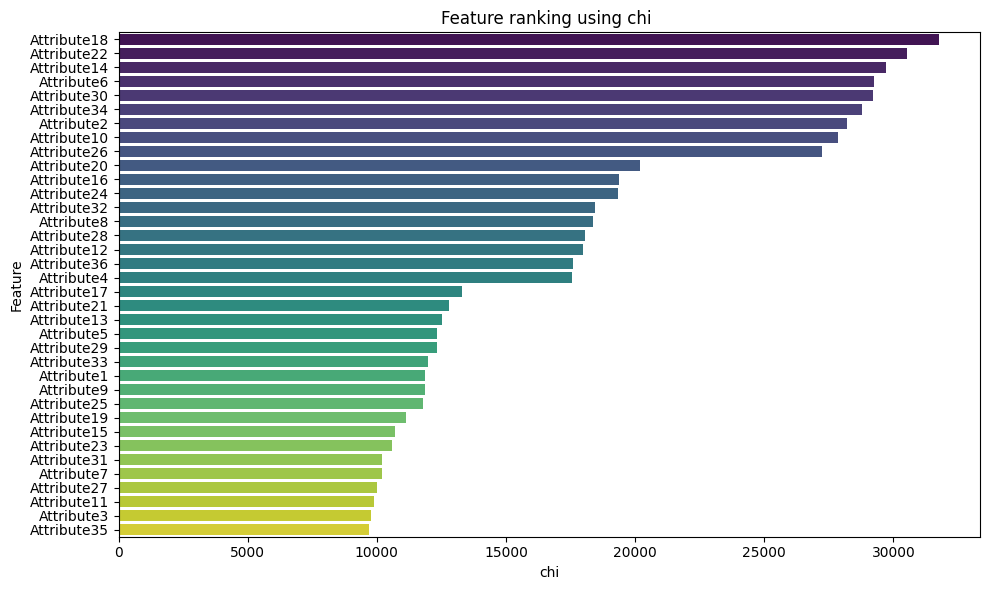

In [76]:
#SORTED BY chi
plt.figure(figsize=(10, 6))
sns.barplot(x='chi', y='Feature', data=ranking_df.sort_values('chi', ascending=False), palette='viridis')
plt.title('Feature ranking using chi ')
plt.xlabel('chi')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

As we can see each method ranked the features in a different order. Nevertheless we can observe that attributes 3, 11 and 25 are in the last places of the 4 rankings, while features 18, 22 and 17 are in the first places in most of the rankings. 

Do a PCA transform on the data

In [77]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

# Step 1: Perform PCA on the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

Select the PCA components that explain 95% of the variance

In [78]:
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance_ratio >= 0.95) + 1  
print(f"Number of PCA components selected: {n_components}")

Number of PCA components selected: 6


In [79]:
X_pca_selected = X_pca[:, :n_components]

Perform Linear Discriminant Analysis (LDA)

In [85]:
y_encoded = LabelEncoder().fit_transform(df['y'])

lda = LinearDiscriminantAnalysis()
lda.fit(X_pca_selected, y_encoded)

LinearDiscriminantAnalysis()

Report the performance of LDA

In [81]:
lda_cv_score = cross_val_score(lda, X_pca_selected, y_encoded, cv=5) 
print(f"Cross-validated accuracy score: {lda_cv_score.mean():.4f}")

Cross-validated accuracy score: 0.8107


In [86]:
y_pred = lda.predict(X_pca_selected)
accuracy = accuracy_score(y_encoded, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8194
